In [87]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [88]:

grid_i = 7
grid_j = 10




#noise = np.random.choice(rang,1,prob)[0]
#wind = np.copy(wind)
#wind[np.where( wind > 0 )] += noise 

#possible action
up = 0
down = 1
left = 2
right = 3
up_left = 4
up_right = 5
down_left = 6
down_right = 7

#greedy policy parameter
epsilon = 0.1
#sarsa step size
alpha = 0.4
#reward for each step
reward = -1.0
gamma = 0.3
lam = 0.8
wind = [0,0,0,1,1,1,2,2,1,0]

start = [3,0]
end = [3,7]
standard_action = [up,down,left,right]
king_action = [up,down,left,right,up_left,up_right,down_left,down_right]

In [89]:
#stochastic wind explanation: for every single wind, it has 1/3 chance of receiving extra noise(-1,0,1)
def step2(state,action):
    i,j = state
    rang = np.arange(-1,2) #[-1,0,1]
    prob = [1./3,1./3,1./3]
    wind = [0,0,0,1,1,1,2,2,1,0]
    noise = np.random.choice(rang,1,prob)[0]
    wind = np.copy(wind)
    wind[np.where(wind > 0)] += noise
    if action == up:
        return [max(i - 1 - wind[j], 0),j]
    elif action == down:
        return [max(min(i + 1 - wind[j], grid_i - 1), 0), j]
    elif action == left:
        return [max(i - wind[j], 0), max(j - 1, 0)]
    elif action == right:
        return [max(i - wind[j], 0), min(j + 1, grid_j -1)]
    elif action == up_left:
        return [max(i - 1 - wind[j], 0), max(j - 1, 0)]
    elif action == up_right:
        return [max(i - 1 - wind[j], 0),min(j + 1, grid_j -1)]
    elif action == down_left:
        return [max(min(i + 1 - wind[j], grid_i - 1), 0), max(j - 1, 0)]
    elif action == down_right:
        return [max(min(i + 1 - wind[j], grid_i - 1), 0),min(j + 1, grid_j -1)]
    else:
        return False

In [90]:
# This is the function to update the state base on the action we take, if the target hits the wall, it would remain
# in the same cell.
def step(state,action):
    i, j = state
    if action == up:
        return [max(i - 1 - wind[j], 0), j]
    elif action == down:
        return [max(min(i + 1 - wind[j], grid_i - 1), 0), j]
    elif action == left:
        return [max(i - wind[j], 0), max(j - 1, 0)]
    elif action == right:
        return [max(i - wind[j], 0), min(j + 1, grid_j - 1)]
    else:
        return False

In [91]:
#greedy policy, epsilon parameter decide the probability we choose other action
#if we dont randomly choose other action, we decide by the max value of the action.
def choose_a(state):
    if np.random.binomial(1, epsilon) == 1:
        action = np.random.choice(king_action)
    else:
        values_ = q_value[state[0], state[1], :]
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])
    return action

In [92]:
#q_learning algorithm, ep means epsiode and we use y to count steps for every single episode.
def episode_q_learning(q_value,ep):
    time = 0
    state = start
    action = choose_a(state)

    while state != end:
        next_state = step2(state,action)
        next_action = choose_a(next_state)
        q_value[state[0], state[1], action] += alpha * (reward + gamma * np.max(q_value[next_state[0], next_state[1], :]) - q_value[state[0],state[1],action])
        state = next_state
        action = next_action

        time +=1
    y[ep] = time

    return time,y

In [93]:
def episode_sarsa(q_value,ep):
    time = 0
    state = start
    action = choose_a(state)
    trajectory = [state]
  
    while state != end:
        next_state = step2(state,action)
        next_action = choose_a(next_state)
        #sarsa update
        q_value[state[0], state[1], action] += alpha * (reward + gamma * q_value[next_state[0],next_state[1],next_action] - q_value[state[0],state[1],action])
        state = next_state
        action = next_action
        time +=1
        trajectory.append(state)
    y[ep] = time


    return time,y

In [94]:
#error = target - estimation
#eligibility trace we use here is accumulating trace
#eligibility trace for every state-action pair decays at every step by gamma * lam
def sarsa_lambda(q_value,ep):
    time = 0
    state = start
    action = choose_a(state)
    e = np.zeros((grid_i,grid_j,8))
    while state != end:
        next_state = step2(state,action)
        next_action = choose_a(next_state)
        error = reward + gamma * q_value[next_state[0],next_state[1],next_action] - q_value[state[0],state[1],action]
        e[state[0],state[1],action] += 1
        q_value[state[0],state[1],action] += alpha * error * e[state[0],state[1],action]
        e[state[0],state[1],action] = gamma * lam * e[state[0],state[1],action]
        state = next_state
        action = next_action
        time +=1
    y[ep] = time
    return time,y

In [95]:
#eligibility trace is updated in two steps:
#if an exploratory action was taken, they r set to zero for all state-action pair
#in the second step,in the second step, the e value is in incremented by 1
def q_learning_lambda(q_value,ep):
    time = 0
    state = start
    action = choose_a(state)
    e = np.zeros((grid_i,grid_j,8))
    while state != end:
        next_state = step2(state,action)
        next_action = choose_a(next_state)
       #q_value[state[0], state[1], action] += alpha * (reward + gamma * np.max(q_value[next_state[0], next_state[1], :]) - q_value[state[0],state[1],action])
        best_a = np.argmax(q_value[next_state[0],next_state[1],:])
        error = reward + gamma * q_value[next_state[0],next_state[1],best_a] - q_value[state[0],state[1],action]
        e[state[0],state[1],action] += 1
        q_value[state[0],state[1],action] += alpha * error * e[state[0],state[1],action]
        if next_action == best_a:
            e[state[0],state[1],action] = gamma * lam * e[state[0],state[1],action]
        else:
            e[state[0],state[1],action] = 0
                
        state = next_state
        action = next_action
        time +=1
    y[ep] = time

        
    return time,y

In [96]:
def replacing_trace(state,action):
    e[state[0],state[1],action] = 1
    e[state[0],state[1],action] *= gamma * lam
    return e

In [97]:

#time,steps = episode_sarsa(q_value)
#print(steps)
#a = episode_sarsa(q_value)
episode_limit = 400

steps = []
step2s = []
trace = []
ep = 0

q_value = np.zeros((grid_i,grid_j,8))
e = np.zeros((grid_i,grid_j,8))
y = np.zeros((episode_limit,1))
#this is is to hold how many steps we need to reach the end

ets = np.zeros((episode_limit,1))
ets2 = np.zeros((episode_limit,1))



8 [[ 310.]
 [ 454.]
 [ 359.]
 [1099.]
 [ 213.]
 [ 200.]
 [  82.]
 [ 507.]
 [ 487.]
 [ 203.]
 [  92.]
 [  23.]
 [ 131.]
 [  97.]
 [ 230.]
 [  71.]
 [  31.]
 [  13.]
 [  22.]
 [ 194.]
 [ 361.]
 [  52.]
 [  74.]
 [  44.]
 [ 352.]
 [ 266.]
 [ 294.]
 [  69.]
 [  64.]
 [  51.]
 [ 165.]
 [  25.]
 [  80.]
 [  63.]
 [  39.]
 [  55.]
 [  18.]
 [  26.]
 [  34.]
 [  35.]
 [  29.]
 [ 191.]
 [  67.]
 [  58.]
 [  28.]
 [  41.]
 [ 232.]
 [ 128.]
 [ 371.]
 [  59.]
 [ 361.]
 [  70.]
 [  50.]
 [ 102.]
 [  88.]
 [ 145.]
 [ 270.]
 [ 434.]
 [  15.]
 [ 348.]
 [  74.]
 [ 155.]
 [ 108.]
 [ 114.]
 [  85.]
 [  62.]
 [ 105.]
 [  40.]
 [  42.]
 [ 121.]
 [ 141.]
 [  94.]
 [  50.]
 [  24.]
 [  24.]
 [  31.]
 [ 134.]
 [  77.]
 [  77.]
 [  72.]
 [ 153.]
 [  43.]
 [  21.]
 [  11.]
 [  70.]
 [  86.]
 [  21.]
 [  68.]
 [  62.]
 [  84.]
 [ 101.]
 [ 105.]
 [ 262.]
 [  52.]
 [  57.]
 [ 106.]
 [  58.]
 [ 107.]
 [ 115.]
 [  30.]
 [  41.]
 [  25.]
 [  16.]
 [  76.]
 [  45.]
 [  30.]
 [  39.]
 [  11.]
 [  24.]
 [  28.]
 [  44.]

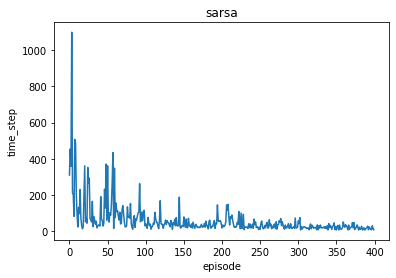

In [98]:

while ep < episode_limit:
    #a = episode_sarsa(q_value)
    time,y = episode_sarsa(q_value,ep)
#     steps.append(episode_sarsa(q_value))
    ets[ep] = time
    ep += 1
print(time,y)

steps = np.add.accumulate(steps)
step2s = np.add.accumulate(step2s)
print(ets[episode_limit-1])

x = np.arange(episode_limit)
plt.plot(x , y)
#plt.plot(step2s,np.arange(1, len(step2s) + 1))
plt.xlabel('episode')
plt.ylabel('time_step')
plt.title('sarsa')

plt.show()

36 [[1596.]
 [ 597.]
 [ 253.]
 [ 732.]
 [ 839.]
 [ 400.]
 [  39.]
 [ 265.]
 [  85.]
 [ 112.]
 [  94.]
 [ 111.]
 [ 137.]
 [ 329.]
 [ 117.]
 [ 205.]
 [ 483.]
 [  19.]
 [ 334.]
 [ 257.]
 [ 194.]
 [  29.]
 [  22.]
 [  63.]
 [  20.]
 [  53.]
 [  66.]
 [  29.]
 [  62.]
 [  29.]
 [  44.]
 [  45.]
 [  53.]
 [  26.]
 [ 116.]
 [  44.]
 [  29.]
 [ 162.]
 [  48.]
 [  19.]
 [ 202.]
 [ 128.]
 [  52.]
 [  22.]
 [  88.]
 [  51.]
 [  19.]
 [  74.]
 [  35.]
 [ 118.]
 [  47.]
 [  31.]
 [  50.]
 [  52.]
 [  58.]
 [  15.]
 [  24.]
 [  35.]
 [  17.]
 [  67.]
 [  17.]
 [  35.]
 [  31.]
 [  55.]
 [  40.]
 [ 138.]
 [ 109.]
 [  29.]
 [   7.]
 [ 127.]
 [  50.]
 [  72.]
 [  30.]
 [  37.]
 [  68.]
 [  54.]
 [  57.]
 [ 132.]
 [ 201.]
 [  23.]
 [  12.]
 [  49.]
 [  71.]
 [  66.]
 [ 136.]
 [  11.]
 [ 287.]
 [  21.]
 [ 143.]
 [ 237.]
 [  38.]
 [  17.]
 [  28.]
 [  47.]
 [  34.]
 [  35.]
 [ 200.]
 [  80.]
 [  20.]
 [  78.]
 [ 112.]
 [  77.]
 [  37.]
 [  67.]
 [  74.]
 [  30.]
 [  29.]
 [  44.]
 [  23.]
 [  20.]
 [  15.

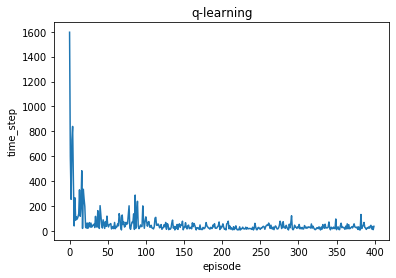

In [99]:
ep = 0
q_value = q_value = np.zeros((grid_i,grid_j,8))
while ep < episode_limit:
    #a = episode_sarsa(q_value)
    time,y = episode_q_learning(q_value,ep)
#     steps.append(episode_sarsa(q_value))
    ets2[ep] = time
    ep += 1
print(time,y)
print(len(y))
steps = np.add.accumulate(steps)
step2s = np.add.accumulate(step2s)
print(ets2[episode_limit-1])

x = np.arange(episode_limit)
plt.plot(x , y)
#plt.plot(step2s,np.arange(1, len(step2s) + 1))
plt.xlabel('episode')
plt.ylabel('time_step')
plt.title('q-learning')

plt.show()

9 [[ 544.]
 [ 233.]
 [1013.]
 [  30.]
 [ 234.]
 [ 185.]
 [ 344.]
 [ 440.]
 [ 534.]
 [ 392.]
 [ 138.]
 [ 149.]
 [ 191.]
 [  51.]
 [  55.]
 [  66.]
 [  88.]
 [  94.]
 [ 159.]
 [  71.]
 [  35.]
 [   9.]
 [  54.]
 [  19.]
 [ 254.]
 [  47.]
 [ 295.]
 [ 359.]
 [ 240.]
 [  22.]
 [ 104.]
 [ 515.]
 [ 109.]
 [ 173.]
 [  93.]
 [  22.]
 [ 195.]
 [  42.]
 [  94.]
 [  45.]
 [  47.]
 [  32.]
 [  51.]
 [  63.]
 [  27.]
 [  25.]
 [  19.]
 [  83.]
 [  96.]
 [  30.]
 [  29.]
 [  22.]
 [  17.]
 [ 132.]
 [  32.]
 [  98.]
 [  22.]
 [ 123.]
 [  47.]
 [ 154.]
 [ 187.]
 [  39.]
 [ 161.]
 [  66.]
 [  28.]
 [  49.]
 [ 107.]
 [  30.]
 [  60.]
 [ 249.]
 [  52.]
 [ 176.]
 [  30.]
 [  23.]
 [  67.]
 [  71.]
 [  44.]
 [  75.]
 [  40.]
 [  23.]
 [ 185.]
 [  48.]
 [ 290.]
 [  78.]
 [ 102.]
 [  63.]
 [  41.]
 [  47.]
 [  48.]
 [ 164.]
 [  53.]
 [ 118.]
 [  49.]
 [ 129.]
 [  99.]
 [  24.]
 [  96.]
 [  32.]
 [  56.]
 [  13.]
 [  96.]
 [  17.]
 [  32.]
 [  43.]
 [  43.]
 [  71.]
 [  24.]
 [ 130.]
 [  43.]
 [  16.]
 [  10.]

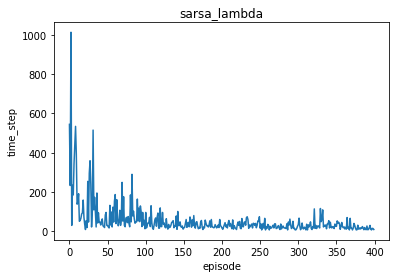

In [100]:
ep = 0
q_value = q_value = np.zeros((grid_i,grid_j,8))
while ep < episode_limit:
    #a = episode_sarsa(q_value)
    time,y = sarsa_lambda(q_value,ep)
#     steps.append(episode_sarsa(q_value))
    ets[ep] = time
    ep += 1
print(time,y)
# steps = np.add.accumulate(steps)
# step2s = np.add.accumulate(step2s)
print(ets[episode_limit-1])

x = np.arange(episode_limit)
plt.plot(x , y)
#plt.plot(step2s,np.arange(1, len(step2s) + 1))
plt.xlabel('episode')
plt.ylabel('time_step')
plt.title('sarsa_lambda')

plt.show()

8 [[ 587.]
 [1115.]
 [  97.]
 [ 438.]
 [ 393.]
 [ 351.]
 [  50.]
 [  89.]
 [ 198.]
 [  83.]
 [  31.]
 [ 268.]
 [ 147.]
 [ 177.]
 [ 179.]
 [ 400.]
 [  60.]
 [ 264.]
 [ 161.]
 [ 102.]
 [  28.]
 [ 501.]
 [ 617.]
 [ 211.]
 [  23.]
 [ 147.]
 [  19.]
 [  37.]
 [  67.]
 [  80.]
 [  61.]
 [ 106.]
 [  52.]
 [  37.]
 [ 338.]
 [  18.]
 [  23.]
 [  53.]
 [  33.]
 [  75.]
 [  85.]
 [  44.]
 [  76.]
 [ 134.]
 [  43.]
 [  22.]
 [  43.]
 [  28.]
 [  40.]
 [ 109.]
 [  46.]
 [  92.]
 [  61.]
 [  89.]
 [  96.]
 [  73.]
 [ 131.]
 [  39.]
 [  74.]
 [  33.]
 [  88.]
 [  49.]
 [  31.]
 [  33.]
 [ 267.]
 [ 457.]
 [  55.]
 [  85.]
 [  23.]
 [  33.]
 [  99.]
 [  46.]
 [  58.]
 [  62.]
 [  28.]
 [  54.]
 [  65.]
 [  63.]
 [  85.]
 [  52.]
 [  47.]
 [  37.]
 [  38.]
 [  10.]
 [  77.]
 [  43.]
 [  32.]
 [  60.]
 [  29.]
 [  22.]
 [   9.]
 [   7.]
 [  30.]
 [  31.]
 [ 109.]
 [  26.]
 [  61.]
 [  36.]
 [  40.]
 [  78.]
 [  31.]
 [  75.]
 [  23.]
 [  59.]
 [ 127.]
 [  39.]
 [  47.]
 [  46.]
 [  38.]
 [  44.]
 [  19.]

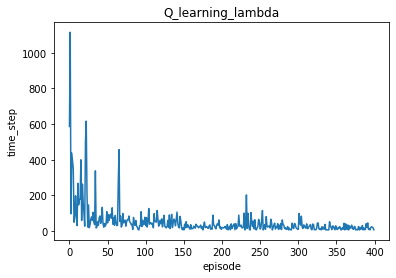

In [101]:
ep = 0
q_value = np.zeros((grid_i,grid_j,8))
while ep < episode_limit:
    #a = episode_sarsa(q_value)
    time,y = q_learning_lambda(q_value,ep)
#     steps.append(episode_sarsa(q_value))
    ets[ep] = time
    ep += 1
print(time,y)
# steps = np.add.accumulate(steps)
# step2s = np.add.accumulate(step2s)
print(ets[episode_limit-1])

x = np.arange(episode_limit)
plt.plot(x , y)
#plt.plot(step2s,np.arange(1, len(step2s) + 1))
plt.xlabel('episode')
plt.ylabel('time_step')
plt.title('Q_learning_lambda')

plt.show()